Parametri globali

In [1]:
C=1.0
tol=0.001
nfold=10

Import librerie

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import unicodedata
from lime import lime_text

Import dataset

In [3]:
df = pd.read_excel('./politica.xlsx', sheet_name="Foglio1")
print(f'Found {len(df)} texts.')

print(f'{df["cap_maj_master"].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df['cap_maj_master'])]

print(f'{df["testo"].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df['testo'])]

classes = [int(c) for c in df['cap_maj_master']]
documents = [d for d in df['testo']]

Found 5674 texts.
2 document(s) with no classification removed
424 document(s) with no text removed


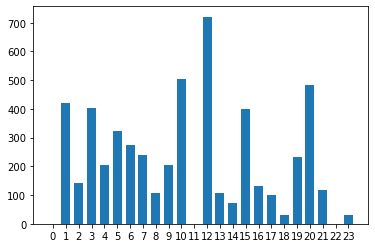

In [4]:
y = np.bincount(classes)
x = np.arange(len(y))
fig, ax = plt.subplots()
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()


preprocessing

In [5]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words('italian'))

def tokenizer_porter(text):
    word_tokens = word_tokenize(text)
    stemmer = SnowballStemmer("italian", ignore_stopwords=True)
    return [stemmer.stem(word) for word in word_tokens]
  

def tokenizer(text):
    stop=set(stopwords.words('italian'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    filtered_sentence = [w for w in filtered_sentence if len(w)>3]
    return filtered_sentence

create vocabolary

In [6]:
tfidf = TfidfVectorizer(strip_accents=strip_accents,
                        lowercase=False,
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_porter,
                        stop_words=stop,
                        min_df = 4
                       )

final_features = tfidf.fit_transform(documents)

In [7]:
X_names=tfidf.get_feature_names()
x_best_s=SelectKBest(chi2, k="all")
p_value_limit = 0.95

Text(0.5, 1.0, 'Sparse Matrix Sample')

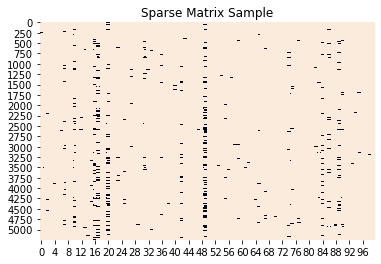

In [8]:
sns.heatmap(final_features.todense()[:,np.random.randint(0,final_features.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [9]:

dtf_features = pd.DataFrame()
for cat in np.unique(classes):
    appoggio=(cat==classes)
    appoggio.astype(int)
    xbest=x_best_s.fit_transform(final_features, appoggio)
    p = x_best_s.pvalues_
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [10]:
for cat in np.unique(classes):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
    print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
    print(" ")

# 1:
  . selected features: 136
  . top features: mezzogiorn,fiat,industrial,inflazion,fiscal,produtt,tern,occupazional,imeres,eni
 
# 2:
  . selected features: 163
  . top features: crocifiss,islam,omosessual,religion,relig,unar,razzial,cattol,confession,cult
 
# 3:
  . selected features: 211
  . top features: farmac,medic,ospedal,ospedalier,pazient,sal,sanitar,vaccin,embrion,malatt
 
# 4:
  . selected features: 182
  . top features: agricol,agricoltor,agricoltur,allev,animal,latt,pesc,produttor,produzion,bovin
 
# 5:
  . selected features: 115
  . top features: lavor,pension,pensionist,infortun,sindacal,inps,forner,previdenzial,voucher,disoccup
 
# 6:
  . selected features: 111
  . top features: abilit,alunn,didatt,docent,format,graduator,insegn,istruzion,paritar,scolast
 
# 7:
  . selected features: 238
  . top features: ambiental,bonif,discar,inquin,rif,smalt,acque,termovalorizz,ecoball,ambient
 
# 8:
  . selected features: 130
  . top features: elettr,energ,energet,gas,gasdott,nuc

In [11]:
tfidf = TfidfVectorizer(strip_accents=strip_accents,
                        lowercase=False,
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_porter,
                        stop_words=stop,
                        min_df = 4,
                        vocabulary=X_names
                       )

final_features = tfidf.fit_transform(documents)

Text(0.5, 1.0, 'Sparse Matrix Sample')

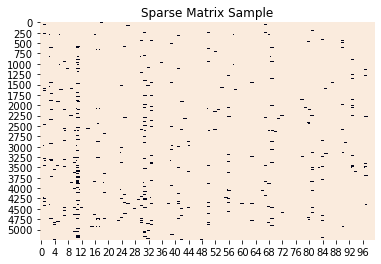

In [12]:
sns.heatmap(final_features.todense()[:,np.random.randint(0,final_features.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [13]:
print(final_features.toarray().shape)

(5248, 2612)


In [14]:
pipe_lr = make_pipeline(
                        tfidf,
                        PassiveAggressiveClassifier(C=C,tol=tol)
                        )

--------------- Fold:  1 ---------------------

Accuracy: 0.7
Detail:
              precision    recall  f1-score   support

           1       0.50      0.57      0.53        42
           2       0.67      0.80      0.73        15
           3       0.82      0.80      0.81        40
           4       0.95      0.90      0.93        21
           5       0.71      0.75      0.73        32
           6       0.84      0.78      0.81        27
           7       0.81      0.88      0.84        24
           8       0.75      0.82      0.78        11
           9       0.64      0.80      0.71        20
          10       0.86      0.86      0.86        50
          12       0.73      0.67      0.70        73
          13       0.50      0.45      0.48        11
          14       1.00      0.43      0.60         7
          15       0.59      0.65      0.62        40
          16       0.75      0.69      0.72        13
          17       0.50      0.20      0.29        10
          1

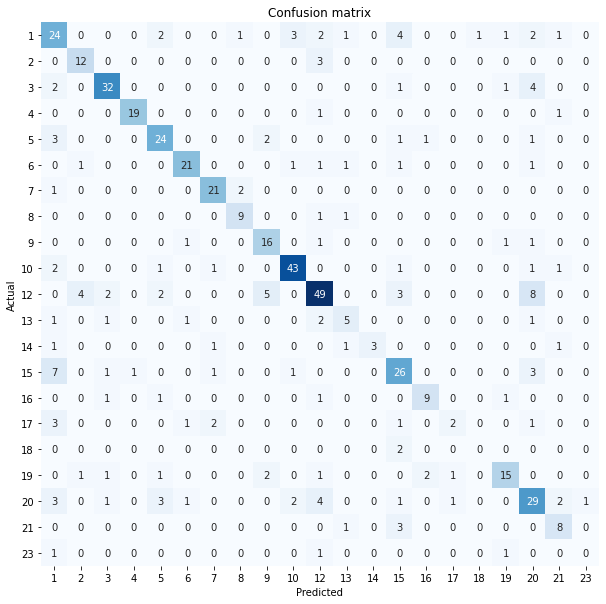

--------------- Fold:  2 ---------------------

Accuracy: 0.69
Detail:
              precision    recall  f1-score   support

           1       0.60      0.62      0.61        42
           2       0.53      0.60      0.56        15
           3       0.88      0.88      0.88        40
           4       0.70      0.67      0.68        21
           5       0.61      0.59      0.60        32
           6       0.84      0.78      0.81        27
           7       0.88      0.88      0.88        24
           8       0.64      0.82      0.72        11
           9       0.55      0.60      0.57        20
          10       0.86      0.86      0.86        50
          12       0.73      0.75      0.74        72
          13       0.60      0.82      0.69        11
          14       0.60      0.86      0.71         7
          15       0.58      0.55      0.56        40
          16       0.79      0.85      0.81        13
          17       0.60      0.60      0.60        10
          

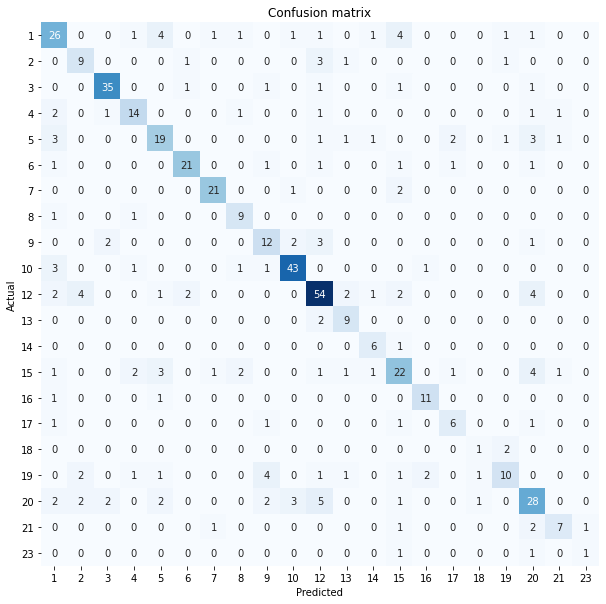

--------------- Fold:  3 ---------------------

Accuracy: 0.66
Detail:
              precision    recall  f1-score   support

           1       0.44      0.45      0.45        42
           2       0.43      0.40      0.41        15
           3       0.78      0.80      0.79        40
           4       0.94      0.80      0.86        20
           5       0.70      0.58      0.63        33
           6       0.75      0.75      0.75        28
           7       0.70      0.67      0.68        24
           8       0.82      0.82      0.82        11
           9       0.87      0.65      0.74        20
          10       0.91      0.78      0.84        50
          12       0.71      0.79      0.75        72
          13       0.67      0.73      0.70        11
          14       0.60      0.43      0.50         7
          15       0.50      0.60      0.55        40
          16       0.69      0.69      0.69        13
          17       0.64      0.70      0.67        10
          

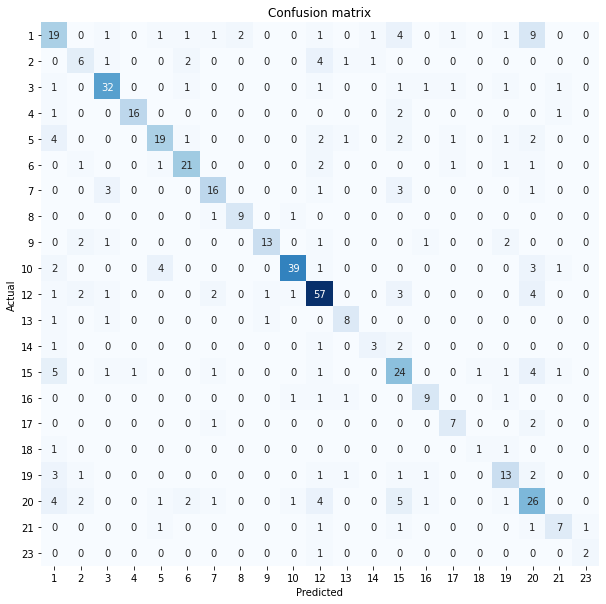

--------------- Fold:  4 ---------------------

Accuracy: 0.66
Detail:
              precision    recall  f1-score   support

           1       0.56      0.45      0.50        42
           2       0.67      0.43      0.52        14
           3       0.87      0.82      0.85        40
           4       0.68      0.65      0.67        20
           5       0.71      0.73      0.72        33
           6       0.87      0.93      0.90        28
           7       0.84      0.88      0.86        24
           8       0.58      0.64      0.61        11
           9       0.73      0.80      0.76        20
          10       0.88      0.88      0.88        50
          12       0.72      0.69      0.71        72
          13       0.36      0.45      0.40        11
          14       0.50      0.29      0.36         7
          15       0.38      0.42      0.40        40
          16       0.62      0.77      0.69        13
          17       0.56      0.50      0.53        10
          

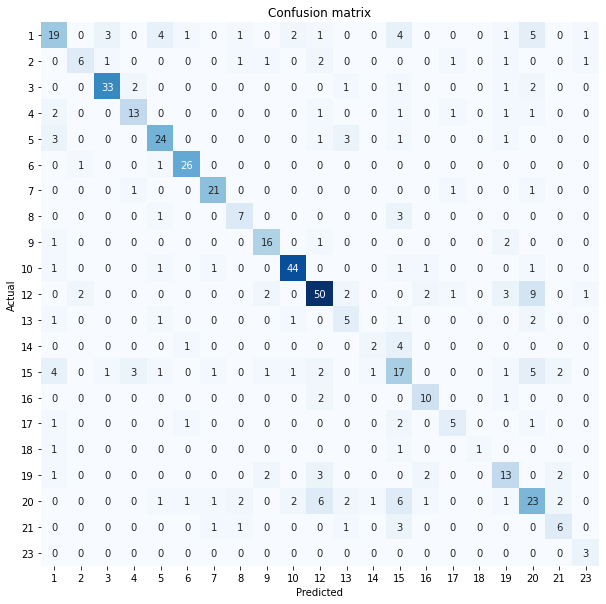

--------------- Fold:  5 ---------------------

Accuracy: 0.67
Detail:
              precision    recall  f1-score   support

           1       0.57      0.55      0.56        42
           2       0.44      0.50      0.47        14
           3       0.81      0.75      0.78        40
           4       0.65      0.55      0.59        20
           5       0.68      0.64      0.66        33
           6       0.85      0.79      0.81        28
           7       0.73      0.70      0.71        23
           8       0.73      0.73      0.73        11
           9       0.73      0.80      0.76        20
          10       0.81      0.92      0.86        50
          12       0.79      0.75      0.77        72
          13       0.36      0.36      0.36        11
          14       0.83      0.71      0.77         7
          15       0.54      0.62      0.58        40
          16       0.71      0.71      0.71        14
          17       0.46      0.60      0.52        10
          

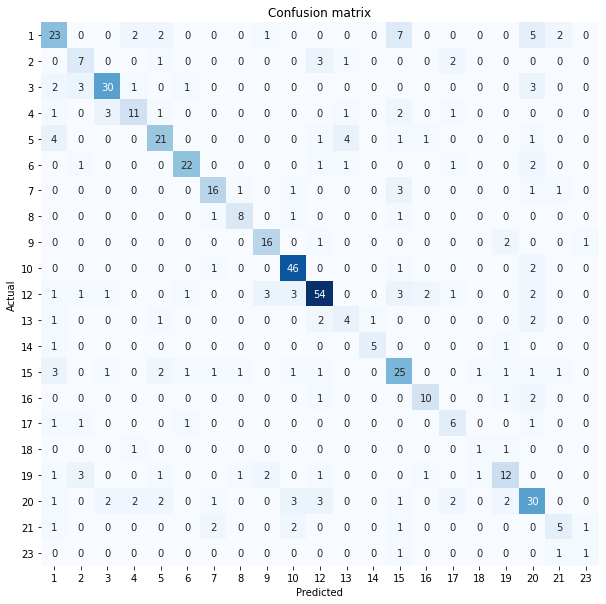

--------------- Fold:  6 ---------------------

Accuracy: 0.64
Detail:
              precision    recall  f1-score   support

           1       0.49      0.52      0.51        42
           2       0.40      0.29      0.33        14
           3       0.85      0.82      0.84        40
           4       0.80      0.80      0.80        20
           5       0.50      0.55      0.52        33
           6       0.73      0.70      0.72        27
           7       0.74      0.58      0.65        24
           8       0.73      0.73      0.73        11
           9       0.68      0.65      0.67        20
          10       0.82      0.88      0.85        51
          12       0.71      0.69      0.70        72
          13       0.20      0.18      0.19        11
          14       0.75      0.86      0.80         7
          15       0.59      0.60      0.59        40
          16       0.60      0.43      0.50        14
          17       0.62      0.50      0.56        10
          

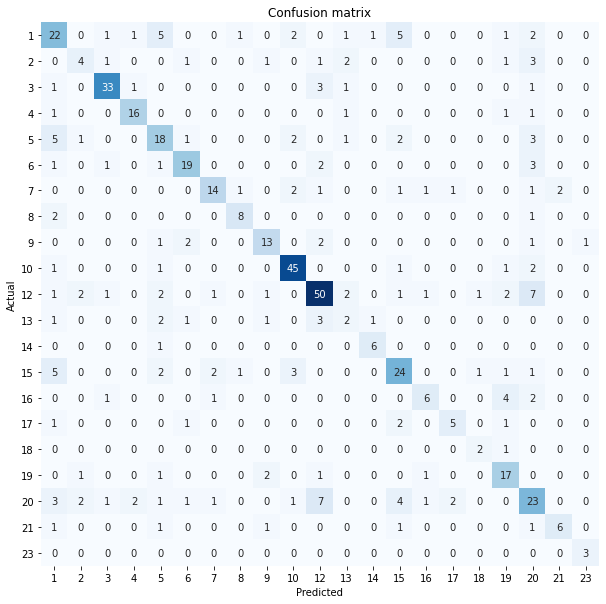

--------------- Fold:  7 ---------------------

Accuracy: 0.66
Detail:
              precision    recall  f1-score   support

           1       0.52      0.62      0.57        42
           2       0.45      0.36      0.40        14
           3       0.86      0.88      0.87        41
           4       0.79      0.75      0.77        20
           5       0.63      0.53      0.58        32
           6       0.70      0.78      0.74        27
           7       0.72      0.75      0.73        24
           8       0.86      0.55      0.67        11
           9       0.88      0.71      0.79        21
          10       0.80      0.84      0.82        51
          12       0.69      0.72      0.71        72
          13       0.57      0.36      0.44        11
          14       0.62      0.71      0.67         7
          15       0.41      0.44      0.43        39
          16       0.82      0.69      0.75        13
          17       0.67      0.73      0.70        11
          

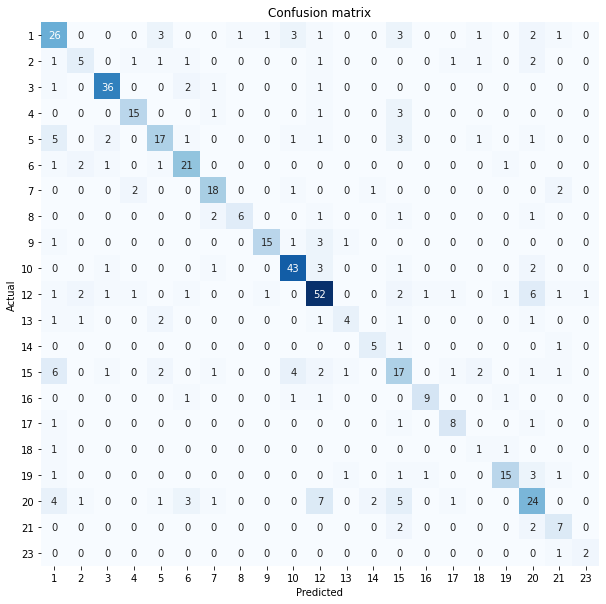

c:\users\berto\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------- Fold:  8 ---------------------

Accuracy: 0.67
Detail:
              precision    recall  f1-score   support

           1       0.60      0.62      0.61        42
           2       0.75      0.43      0.55        14
           3       0.88      0.88      0.88        41
           4       0.80      0.57      0.67        21
           5       0.69      0.62      0.66        32
           6       0.73      0.70      0.72        27
           7       0.65      0.71      0.68        24
           8       0.67      0.60      0.63        10
           9       0.70      0.76      0.73        21
          10       0.76      0.82      0.79        51
          12       0.74      0.78      0.76        72
          13       0.67      0.80      0.73        10
          14       1.00      0.38      0.55         8
          15       0.49      0.60      0.54        40
          16       0.62      0.62      0.62        13
          17       0.62      0.80      0.70        10
          

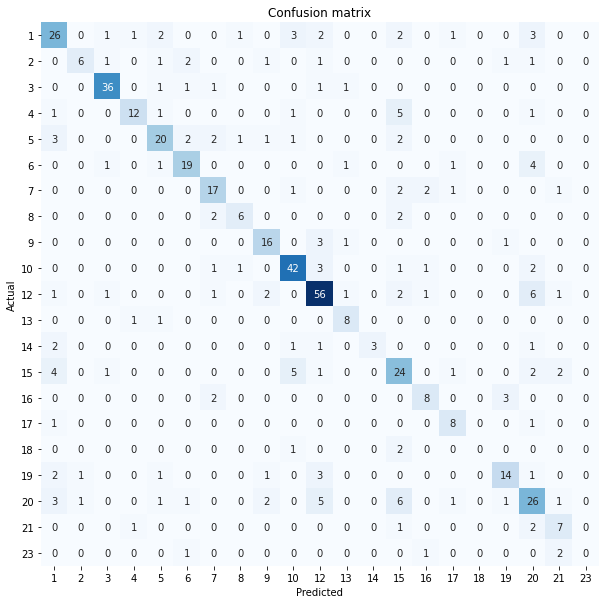

--------------- Fold:  9 ---------------------

Accuracy: 0.71
Detail:
              precision    recall  f1-score   support

           1       0.62      0.67      0.64        42
           2       0.70      0.50      0.58        14
           3       0.88      0.85      0.86        41
           4       0.72      0.86      0.78        21
           5       0.81      0.53      0.64        32
           6       0.89      0.93      0.91        27
           7       0.73      0.79      0.76        24
           8       0.64      0.90      0.75        10
           9       0.74      0.81      0.77        21
          10       0.77      0.78      0.78        51
          12       0.75      0.85      0.80        72
          13       0.43      0.30      0.35        10
          14       1.00      0.88      0.93         8
          15       0.53      0.45      0.49        40
          16       0.73      0.62      0.67        13
          17       0.71      0.50      0.59        10
          

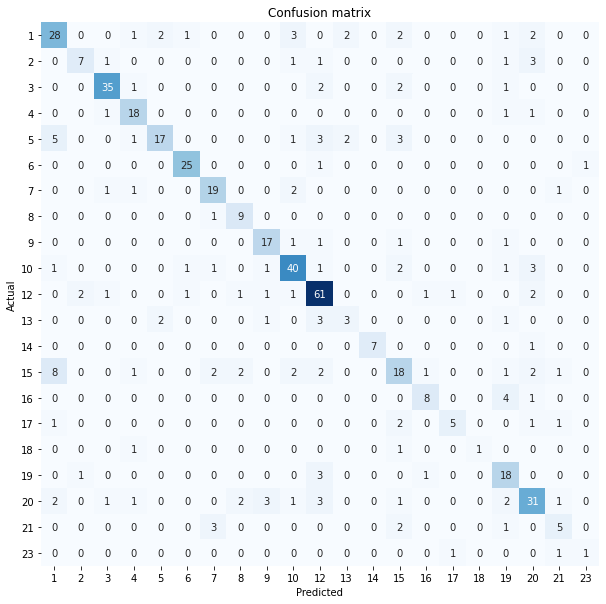

--------------- Fold: 10 ---------------------

Accuracy: 0.68
Detail:
              precision    recall  f1-score   support

           1       0.60      0.69      0.64        42
           2       0.70      0.50      0.58        14
           3       0.91      0.80      0.85        40
           4       0.80      0.76      0.78        21
           5       0.77      0.72      0.74        32
           6       0.72      0.78      0.75        27
           7       0.68      0.62      0.65        24
           8       0.75      0.60      0.67        10
           9       0.68      0.85      0.76        20
          10       0.88      0.84      0.86        51
          12       0.74      0.75      0.74        72
          13       0.50      0.40      0.44        10
          14       0.62      0.62      0.62         8
          15       0.51      0.45      0.48        40
          16       0.65      0.85      0.73        13
          17       0.36      0.40      0.38        10
          

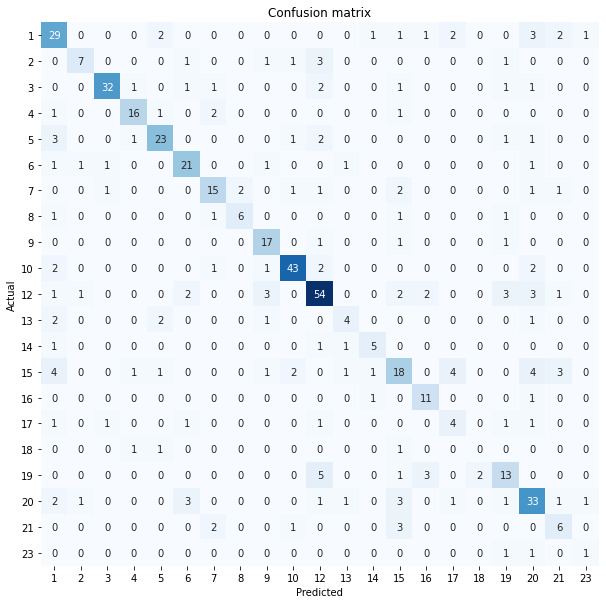

Overall results of the cross-validation procedure


CV accuracy: 67.5 +/- 2.1

CV precision: 67.9 +/- 2.0

CV recall: 67.5 +/- 2.1

CV f1: 67.3 +/- 2.0


In [15]:
X=np.array(documents)
y=np.array(classes)
kfold = StratifiedKFold(n_splits=nfold,shuffle=True,random_state=1).split(X, y)

accuracys = []
scores= []
target_names=list(map(str,np.unique(classes)))

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X[train], y[train])
    y_pred=pipe_lr.predict(X[test])
    
    ## calcolo accuracy
    accuracy = pipe_lr.score(X[test], y[test])
    accuracys.append(accuracy)
    
    ## calcolo precision,recall,fscore
    score=precision_recall_fscore_support(y_true=y[test], y_pred=y_pred, average="weighted")
    scores.append(score[0:3])
    
    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    print("Accuracy:",  round(accuracy,2))
    print("Detail:")
    print(metrics.classification_report(y[test], y_pred))
    
    ## Plot confusion matrix
    conf_mat = confusion_matrix(y[test], y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cbar=False,cmap=plt.cm.Blues)
    ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=target_names, 
           yticklabels=target_names, title="Confusion matrix")
    plt.yticks(rotation=0)
    
    print()
    
    
    plt.show()
    
    

    
arr = np.array(scores)

print("Overall results of the cross-validation procedure")
print()

print('\nCV accuracy: %.1f +/- %.1f' % (np.mean(accuracys)*100, np.std(accuracys)*100))
print('\nCV precision: %.1f +/- %.1f' % (np.mean(arr[:,0])*100, np.std(arr[:,0])*100))
print('\nCV recall: %.1f +/- %.1f' % (np.mean(arr[:,1])*100, np.std(arr[:,1])*100))
print('\nCV f1: %.1f +/- %.1f' % (np.mean(arr[:,2])*100, np.std(arr[:,2])*100))